<a href="https://colab.research.google.com/github/RajKGupta/MIDAS_Labs/blob/master/Task2_Vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MIDAS LABS - Vision Task

Basic commands for plotting the images within the jupyter notebooks and refreshing the notebook whenever it detects a change in the files.


In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

We import all the necessary packages. We are going to work with the [fastai V1 library](http://www.fast.ai/2018/10/02/fastai-ai/) which sits on top of [Pytorch 1.0](https://hackernoon.com/pytorch-1-0-468332ba5163). The fastai library provides many useful functions that enable us to quickly and easily build neural networks and train our models.

In [0]:
from fastai.vision import *
from fastai.metrics import error_rate

Lets first download the dataset. I have uploaded the dataset in Dropbox and made the link public. After downloding the files are unizipped.

In [3]:
!wget https://www.dropbox.com/s/vxjqkxebiafg6vm/iiitd.zip

--2019-04-08 11:36:10--  https://www.dropbox.com/s/vxjqkxebiafg6vm/iiitd.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.1, 2620:100:6021:1::a27d:4101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/vxjqkxebiafg6vm/iiitd.zip [following]
--2019-04-08 11:36:11--  https://www.dropbox.com/s/raw/vxjqkxebiafg6vm/iiitd.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc4a76d7ed8978f169528870b6ec.dl.dropboxusercontent.com/cd/0/inline/AelNPQP0IqoA4k35Iwo6Z9dhduf5FkTaL47Irm0aOrKpA2-Bjargiy4TTOAqmnNit1763RvsZW8r-PcO2sb3Z1hEQPdmpVvHMQ4lMAwqt_9yug/file# [following]
--2019-04-08 11:36:11--  https://uc4a76d7ed8978f169528870b6ec.dl.dropboxusercontent.com/cd/0/inline/AelNPQP0IqoA4k35Iwo6Z9dhduf5FkTaL47Irm0aOrKpA2-Bjargiy4TTOAqmnNit1763RvsZW8r-PcO2sb3Z1hEQPdmpVvHMQ4lMAwqt_9yug/file
Resolving uc4a76d7ed8978f

In [5]:
!unzip iiitd.zip

Archive:  iiitd.zip
  inflating: train_label.pkl         
  inflating: hitkul(sample_submission).csv  
  inflating: test_image.pkl          
  inflating: train_image.pkl         


Now we will use pickle to unpickle the files and use numpy and matplotlib to see the images.

In [0]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

In [0]:
def open_pickel_file(filename):   # function to read the pickel file
  file = open(filename, "rb")
  data = pickle.load(file)
  file.close()
  train = []
  for item in data:
    train.append(item)
  unpickled_data = np.array(train)
  del train 

  return unpickled_data


In [0]:
# reading the train data, test data and train data labels
train_image_data = open_pickel_file("train_image.pkl") 
train_image_label = open_pickel_file("train_label.pkl")
test_image_data = open_pickel_file("test_image.pkl")


Now let us do same basic inference about the data. There seems to 8000 train images and 2000 test images.

Each image has been flattened into 1 - D array and since each image seems to be 784 pixel long therefore we can reasonably guess that the image had originally been of size 28*28.

In [7]:
train_image_data.shape

(8000, 784)

In [8]:
test_image_data.shape

(2000, 784)

In [9]:
train_image_label.shape
  

(8000,)

In [0]:
def display_image(num,x_train,y_train): # dipslay imagewith label
    print(y_train[num])
    label = y_train[num].argmax(axis=0)
    image = x_train[num].reshape([28,28])
    plt.title('Example: %d  Label: %d' % (num, label))
    plt.imshow(image, cmap=plt.get_cmap('gray_r'),vmin=0,vmax=255)
    plt.show()

0


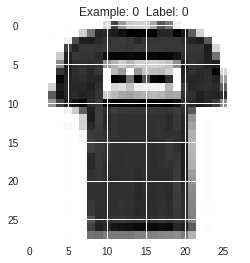

In [14]:
display_image(0,train_image_data,train_image_label) # change 0 to any value less than x_train.shape[0]

The image seems to be of a T-shirt and changing the value one will be able to see the images seem to be of men and women apparells. Now we will check the dataset to see how many different classes  are there and what is the distribution of the training data set.

In [11]:
import pandas as pd
label_df = pd.Series(train_image_label ,dtype='category')
label_df.describe()

count     8000
unique       4
top          6
freq      2000
dtype: int64

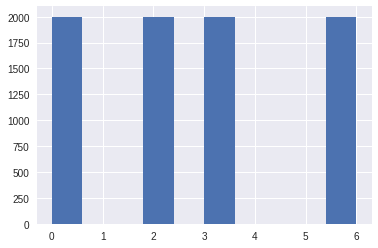

In [12]:
label_df.hist()

So there are 4 classes '2', '3', '0' and '6' and the training data is evenly spread across the 4 classes. Thus we do not need to apply dataset balancing techniques.

In [13]:
label_df.value_counts() 

6    2000
3    2000
2    2000
0    2000
dtype: int64

In [0]:
from PIL import Image
im = Image.fromarray(train_image_data[0].reshape([28,28]).astype('uint8'))
im.save("your_file.png")

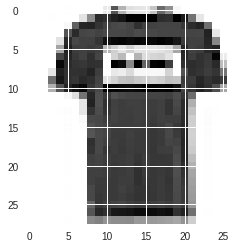

In [14]:
import matplotlib.image as mpimg
img=mpimg.imread('your_file.png')
imgplot = plt.imshow(img)

The FastAI library is high level API like Keras that is based on the PyTorch Framework. It has several utility functions that can help achieve better results as it has incorporated techniques from recent papers like "One-shot Learning" by Leslie Smith. It provides us with a useful DataBunch Object which simplifies several tasks like applying transformations on the dataset for augmentation like rotation, resizing, skewing, tilting and many other. 

Databunch can accept data in several styles like Imagenet folder style or reading labels from csv files. However it cannot  read pickel files directly so we save the images locally in image net style of train and validation folder with images in respective labels subfolders and all the test images in a single folder.

path\
    
    train\
      clas1\
      clas2\
      ...
    
    valid\
      clas1\
      clas2\
      ...
    
    test\

In [0]:
import os
data_folder = './data'
if not os.path.exists(data_folder):
    os.makedirs(data_folder)

In [0]:
# create the base data folder with the train test and valid subfolders

PATH = f'./data'
train_folder = os.path.join(PATH,'train')
val_folder = os.path.join(PATH,'valid')
test_folder = os.path.join(PATH,'test')

if not os.path.exists(train_folder):
    os.makedirs(train_folder)
if not os.path.exists(val_folder):
    os.makedirs(val_folder)
if not os.path.exists(test_folder):
    os.makedirs(test_folder)

Since no separate validation set is provided for verifying the generalizing power of our classifier so we reserve 25% of the train set as the validation set. For this we use the train_test_split method provided by sklearn. We set random state = 42 for reproducibilty so that the same images appear in the validation set across different runs.

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(train_image_data, train_image_label, test_size=0.25, random_state=42)

In [0]:
# function to save the images in the train and test folders. If the subfolders for the classes are not present then they are created
                                                         
def save_images_in_folder(X_train,train_folder,y_train): 
  for i in range(X_train.shape[0]):
    im = Image.fromarray(X_train[i].reshape([28,28]).astype('uint8'))
    if not os.path.exists(os.path.join(train_folder,str(y_train[i]))):
      os.makedirs(os.path.join(train_folder,str(y_train[i])))
    im.save(os.path.join(train_folder,str(y_train[i]),str(i)+".png"))
  
save_images_in_folder(X_train,train_folder,y_train)  # crete train folder
save_images_in_folder(X_valid,val_folder,y_valid)    # create valid folder



In [24]:
os.listdir('./data/train/3')[:5]

['420.png', '5129.png', '332.png', '2589.png', '4429.png']

In [0]:
def save_images_in_folder_testing(X_train,train_folder): #function to create the test folder. Here we do not require the subfolders for classes.
  for i in range(X_train.shape[0]):
    im = Image.fromarray(X_train[i].reshape([28,28]).astype('uint8'))
    im.save(os.path.join(train_folder,str(i)+".png"))

save_images_in_folder_testing(test_image_data,test_folder)

In [26]:
os.listdir('./data')[:5]

['test', 'train', 'valid']

In [27]:
os.listdir('./data/test')[:5]

['635.png', '420.png', '1623.png', '332.png', '1985.png']

In [28]:
!ls

 data				  sample_data	    train_label.pkl
'hitkul(sample_submission).csv'   test_image.pkl    your_file.png
 iiitd.zip			  train_image.pkl


Here we use image augmnetation to make our model robust. The horizontally flip the images as well as use rotation up to 25 degrees. Then we creatre the data bunch object while setting size=28 and our training testing and validation data sets by providing the base path to these folders

If you're using a computer with an unusually small GPU, you may get an out of memory error when running this notebook. If this happens, click Kernel->Restart, uncomment the 2nd line below to use a smaller *batch size*  and try again.

In [0]:
bs=16
tfms = get_transforms(do_flip=True,max_rotate=25) 
data = ImageDataBunch.from_folder(PATH, ds_tfms=tfms, size=28,train='train',valid = 'valid',test = 'test',bs=bs)

Now we will leverage transfer learning and a state of the art Resnet-18 (He et al in 2015) classifier that has been trained on the Imagenet Dataset. The ImageNet dataset consists of 1000 classes of everyday object and a fully provides a very good starting point for initilization of the weigths of our classifier which can be then fine-tuned for our task. 

Since the Image Dataset had RGB Images while our dataset has greyscale images therefore we have copied the same data across the 3 dimensions and normalize it across the traning and validation set. The statistics for the average normalized values is shown below.

In [18]:
data.batch_stats()

[tensor([0.3489, 0.3489, 0.3489]), tensor([0.3456, 0.3456, 0.3456])]

Let us now visulaize some images.

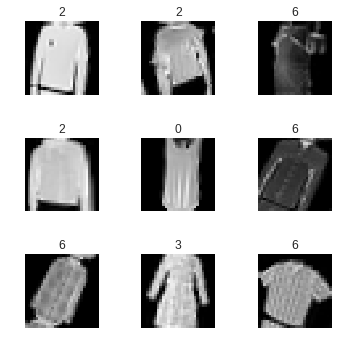

In [19]:
data.show_batch(rows=3, figsize=(5,5))

Now we will create our base classifier fom the Resnet-18 Architecture and then append a global concat pooling layer which concatenates Global Average Pooling and Global Ma Pooling Outputs followerd by 2 fully connected connected layers with suitable dropout layers and batch norm layers and then final linear layer for classification followed by softmax layer. All theses tasks are carried by the fastai library by itself and for now use the default values that work in most cases. However we can tweak the dropout values or create our custom classifier as well.

In [20]:
learn = create_cnn(data, models.resnet18, metrics=accuracy,ps=[0.25,0.3])# create resent-18 classifier initialized with ImageNet weights. ps parameter sets the 
# dropout for the outputs of the linear layers appended after the base classifier. The default values were high and ledd to underfitting.


/usr/local/lib/python3.6/dist-packages/fastai/vision/learner.py:105: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")


In [21]:
learn.model # description of the model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [22]:
learn.summary() # no of parameters across different layers

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 14, 14]         9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 14, 14]         128        True      
______________________________________________________________________
ReLU                 [64, 14, 14]         0          False     
______________________________________________________________________
MaxPool2d            [64, 7, 7]           0          False     
______________________________________________________________________
Conv2d               [64, 7, 7]           36,864     False     
______________________________________________________________________
BatchNorm2d          [64, 7, 7]           128        True      
______________________________________________________________________
ReLU                 [64, 7, 7]           0          False     
______________________________________________________________

In transfer learning we first train our bottom layers while keeping the rest of the classifier fixed. This is because the upper layers are responsible for recognizing and abstracting simpler features like edges while the progressively lower layers identify more complex features. Since we are using transfer learning therefore we need not disturb the upper layers and only train the bottom classifier first as the upper layers are already pretty good. However we will later fine tune the classifier.

We utilize the proposed "One Cycle Learning Technique" by Leslie Smith which utilizes high learning rate to achieve super-convergence. The learnign rate isdropped from a high value to lower value across an epoch which prevents the classifier from getting stuck in a minima.

In [23]:
learn.fit_one_cycle(4) # this trains the data at a high learning rate as proposed by Lesli Smith

epoch,train_loss,valid_loss,accuracy,time
0,1.147159,1.132119,0.572000,00:21
1,0.928162,0.868143,0.668000,00:20
2,0.893610,0.802075,0.688500,00:20
3,0.852170,0.770832,0.696000,00:20


In [0]:
learn.save('stage-1') # save the weights after initial training so that we can revert in case the weights are disturbed in subsequent training

Since the Resnet-18 classifier was originally trained at 224*224 pixels therefore it is better suited for extracting features at that resolution. So we progressively increase the image to that size by zooming in centre cropping it. As can be evidently seen from the increaing accuracy on validation set this technique produces great result and also produce image augmentation effect.

In [0]:

data = ImageDataBunch.from_folder(PATH, ds_tfms=tfms, size=64,train='train',valid = 'valid',test = 'test',bs=bs)
learn.data = data

In [26]:
learn.fit_one_cycle(8)

epoch,train_loss,valid_loss,accuracy,time
0,0.869356,0.790079,0.700500,00:24
1,0.782657,0.619079,0.773500,00:23
2,0.696589,0.577791,0.780500,00:23
3,0.648306,0.541268,0.795000,00:23
4,0.637988,0.494546,0.816000,00:23
5,0.593475,0.461964,0.825000,00:23
6,0.588333,0.467599,0.827500,00:23
7,0.583922,0.477116,0.818500,00:23


In [0]:
learn.save('stage-2')

In [0]:

data = ImageDataBunch.from_folder(PATH, ds_tfms=tfms, size=128,train='train',valid = 'valid',test = 'test',bs=bs)
learn.data = data

In [29]:
learn.fit_one_cycle(8)

epoch,train_loss,valid_loss,accuracy,time
0,0.661042,0.540879,0.794500,00:35
1,0.591218,0.456576,0.827000,00:34
2,0.577438,0.441747,0.830000,00:34
3,0.542187,0.445120,0.822000,00:34
4,0.467612,0.399788,0.845500,00:34
5,0.472771,0.383532,0.846500,00:34
6,0.452986,0.394669,0.838500,00:34
7,0.464396,0.393193,0.843500,00:34


In [0]:
learn.save('stage-3')

In [0]:

data = ImageDataBunch.from_folder(PATH, ds_tfms=tfms, size=224,train='train',valid = 'valid',test = 'test',bs=bs)
learn.data=data

In [32]:
learn.fit_one_cycle(8)

epoch,train_loss,valid_loss,accuracy,time
0,0.564608,0.461805,0.832500,01:08
1,0.519100,0.442883,0.831500,01:07
2,0.491754,0.402444,0.839000,01:08
3,0.505000,0.388853,0.842000,01:08
4,0.459832,0.371170,0.850500,01:08
5,0.409441,0.351299,0.859000,01:09
6,0.382193,0.337973,0.872500,01:09
7,0.408855,0.354231,0.863000,01:08


We have a got a reasonably good classifier however there is a slight underfittiong which we will deal with fine-tuning.

In [0]:
learn.save('stage-4')

In [0]:

data = ImageDataBunch.from_folder(PATH, ds_tfms=tfms, size=224,train='train',valid = 'valid',test = 'test',bs=32)

In [0]:
learn.data = data

In [36]:
learn.fit_one_cycle(8)

epoch,train_loss,valid_loss,accuracy,time
0,0.362524,0.340673,0.872000,01:05
1,0.370588,0.364172,0.856000,01:04
2,0.384758,0.346674,0.869500,01:04
3,0.383727,0.331839,0.873500,01:05
4,0.356822,0.325409,0.875000,01:04
5,0.350019,0.320423,0.879500,01:04
6,0.327954,0.325595,0.873000,01:04
7,0.321688,0.323060,0.873000,01:04


In [0]:
learn.save('stage-5')

In [0]:

data = ImageDataBunch.from_folder(PATH, ds_tfms=tfms, size=224,train='train',valid = 'valid',test = 'test',bs=64)
learn.data = data

In [39]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,accuracy,time
0,0.306534,0.323828,0.876000,01:02
1,0.317983,0.333155,0.871500,01:01
2,0.302557,0.325042,0.870500,01:01
3,0.287365,0.322244,0.871000,01:02


In [0]:
learn.save('stage-6')

Now we have reached a decent accuracy of ~87% lets view the classification produced and plot the confusion matrix

In [40]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

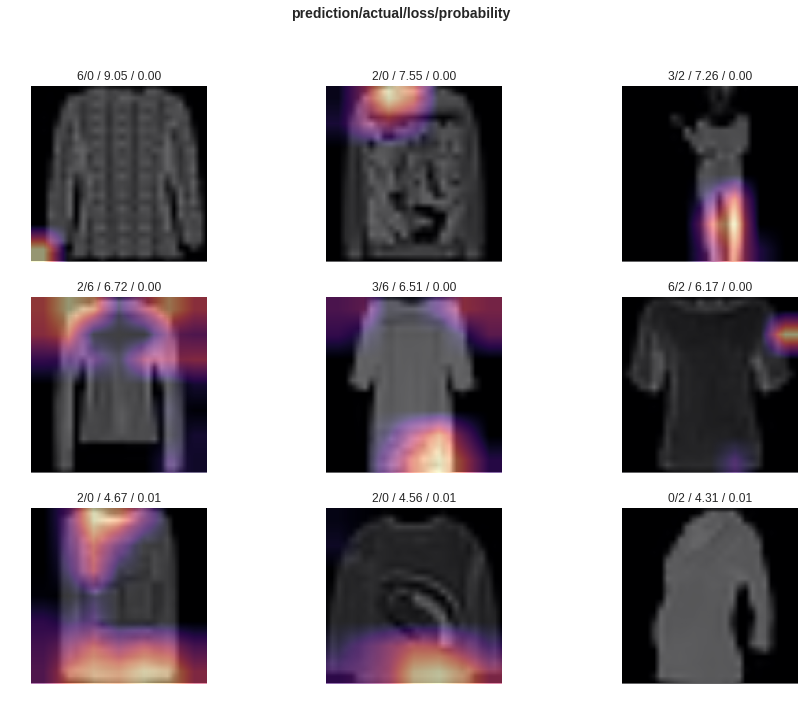

In [41]:
interp.plot_top_losses(9, figsize=(15,11))

The high diagonal values indicate that we are doing a pretty decent job.

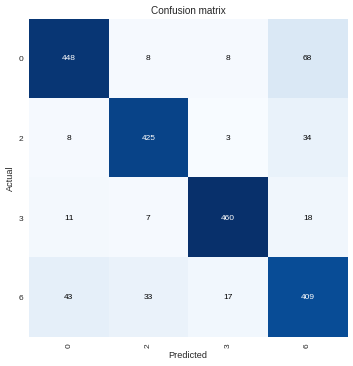

In [42]:
interp.plot_confusion_matrix(figsize=(6,6), dpi=60)

The classifier is largely getting confused between the below classes. We are largely getting class 3 right but the classifier is largely struggling to get 6 right

In [43]:
interp.most_confused(min_val=30)

[('0', '6', 68), ('6', '0', 43), ('2', '6', 34), ('6', '2', 33)]

In [0]:
learn.unfreeze()

In [45]:
learn.summary()

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 112, 112]       9,408      True      
______________________________________________________________________
BatchNorm2d          [64, 112, 112]       128        True      
______________________________________________________________________
ReLU                 [64, 112, 112]       0          False     
______________________________________________________________________
MaxPool2d            [64, 56, 56]         0          False     
______________________________________________________________________
Conv2d               [64, 56, 56]         36,864     True      
______________________________________________________________________
BatchNorm2d          [64, 56, 56]         128        True      
______________________________________________________________________
ReLU                 [64, 56, 56]         0          False     
______________________________________________________________

Now we will unfreeze the classifier and perform fine-tuning. We also make use of another great utility method which helps in selecting the ideal learning rate. The idea is to progressive increase the laerning rate across an epoch. As the learning rate increases the loss continues to decrease until a lowest point and thereafter the loss explodes due to very high gradient backpropogation. The ideal learning rate is slightly before the learning rate chosen at the minima.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


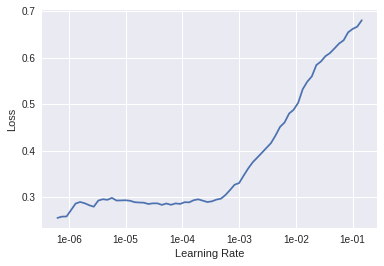

In [47]:
learn.lr_find()
learn.recorder.plot()

In [48]:
learn.fit_one_cycle(5, max_lr=slice(1e-8,5e-6))

epoch,train_loss,valid_loss,accuracy,time
0,0.276400,0.322907,0.868000,01:05
1,0.285392,0.322855,0.873000,01:05
2,0.290983,0.320426,0.873000,01:05
3,0.285849,0.323467,0.871000,01:05
4,0.277305,0.321320,0.871500,01:06


Fine-Tuning will not able to produce much effect in this case beacuse the clothes are also present in the image-net dataset and the upper layers are most-likely already doing a very good job of extracting features.

In [49]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

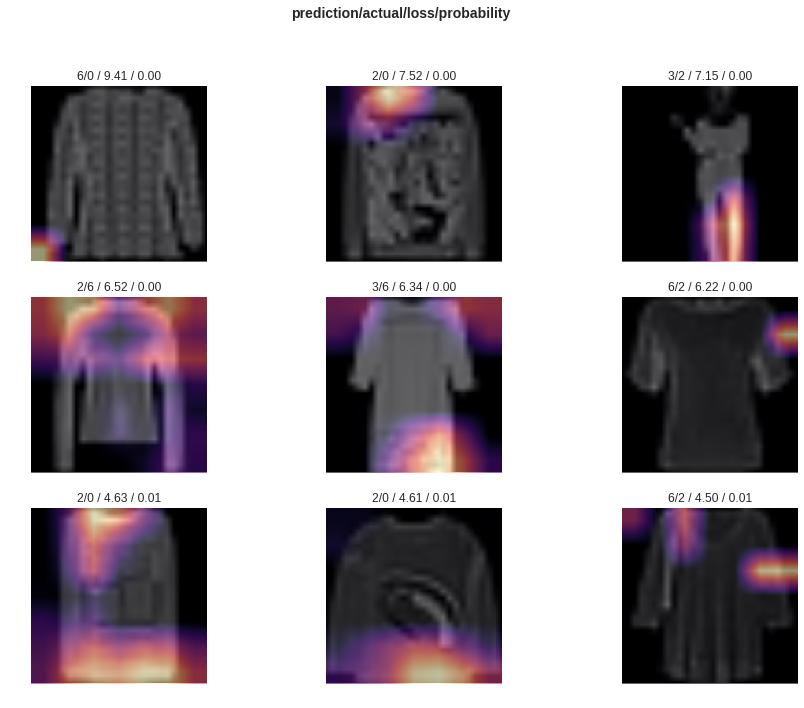

In [50]:
interp.plot_top_losses(9, figsize=(15,11))

In [51]:
interp.most_confused(min_val=30)

[('0', '6', 68), ('6', '0', 43), ('2', '6', 35), ('6', '2', 31)]

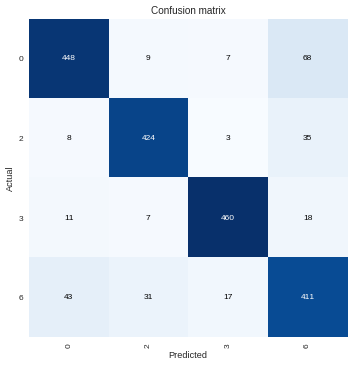

In [52]:
interp.plot_confusion_matrix(figsize=(6,6), dpi=60)

In [0]:
learn.save('final') # we finally save the last weights

In [0]:
learn.export() # this packages the weight and the transformations along with the model in a single file so that it can be run on another machine without the need to train again


In [55]:
os.listdir(PATH)

['models', 'test', 'train', 'export.pkl', 'valid']

In [0]:
learn = load_learner(PATH, test=ImageList.from_folder(f'{PATH}/test'))

Prediction (Category 3, tensor(2), tensor([1.0842e-03, 5.6589e-04, 9.9113e-01, 7.2177e-03]))


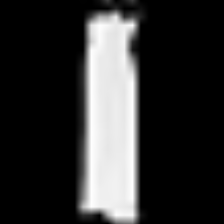

In [57]:
print("Prediction",learn.predict(data.test_ds[10][0])) # a single prediction is made here on the test data provided.
data.test_ds[10][0]

Now lets make the prediction on the entire test dataset. At testing time for best results we have used test time augmentation. Here 8 random manipulations are performed on a single image and then the model is fed each of them and it spews out the softmax scores. These are softmax scores are summed across each image and then an average prediction is made based on that. Ideally it increase the accuracy of the model by ~3-5%. 

In [58]:
preds,y = learn.TTA(ds_type=DatasetType.Test) 

In [0]:
l = data.test_dl.dataset.items

In [60]:
print(preds[0])
print(int(data.classes[int(np.argmax(preds[0],axis=0))]))


tensor([0.1617, 0.6750, 0.0331, 0.1301])
2


In [61]:
preds[:10]

tensor([[1.6171e-01, 6.7503e-01, 3.3129e-02, 1.3013e-01],
        [9.0969e-01, 1.4204e-02, 1.4416e-02, 6.1690e-02],
        [5.6143e-02, 1.5767e-01, 3.1865e-02, 7.5432e-01],
        [9.2805e-01, 4.6497e-03, 1.2999e-02, 5.4297e-02],
        [1.6567e-01, 1.6727e-02, 1.0544e-02, 8.0705e-01],
        [2.7361e-02, 9.0994e-02, 3.0989e-02, 8.5066e-01],
        [2.8996e-01, 1.4422e-02, 3.6783e-03, 6.9194e-01],
        [1.5700e-03, 6.3036e-05, 9.8733e-01, 1.1036e-02],
        [5.2058e-01, 9.1070e-02, 1.4463e-01, 2.4372e-01],
        [2.4257e-01, 5.5842e-04, 1.1688e-01, 6.3999e-01]])

In [0]:
dic = {}
for i in range(len(l)):
  dic[int(l[i].parts[-1][:-4])]=int(data.classes[int(np.argmax(preds[i],axis=0))])


In [63]:
prediction_list = list(dic.items())
from operator import itemgetter
prediction_list.sort(key=itemgetter(0))
prediction_list[:5]

[(0, 0), (1, 0), (2, 0), (3, 0), (4, 0)]

In [0]:
df = pd.DataFrame(prediction_list,columns=['image_index','class'])

In [0]:
df.set_index('image_index',inplace=True)

In [66]:
df.head()

,class
image_index,
0,0
1,0
2,0
3,0
4,0


In [67]:
df.tail()

,class
image_index,
1995,6
1996,6
1997,6
1998,6
1999,6


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8a303c9cf8>]], dtype=object)

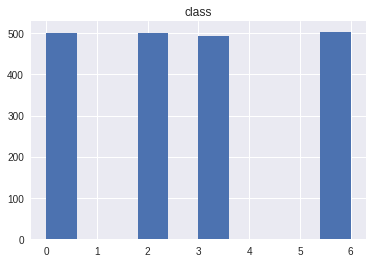

In [68]:
df.hist() # a distribution of the predictions

Now let us export the results in a csv file and make the final submission.

In [0]:
from google.colab import files

df.to_csv('final_prediction.csv')
files.download('final_prediction.csv')